### Assignment 1

### Question 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Packages
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from tqdm import tqdm

# Normality tests
from scipy.stats import jarque_bera, shapiro, anderson
from scipy.stats import anderson, cramervonmises, shapiro, norm, zscore
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import omni_normtest # Doornik-Hansen

import jinja2


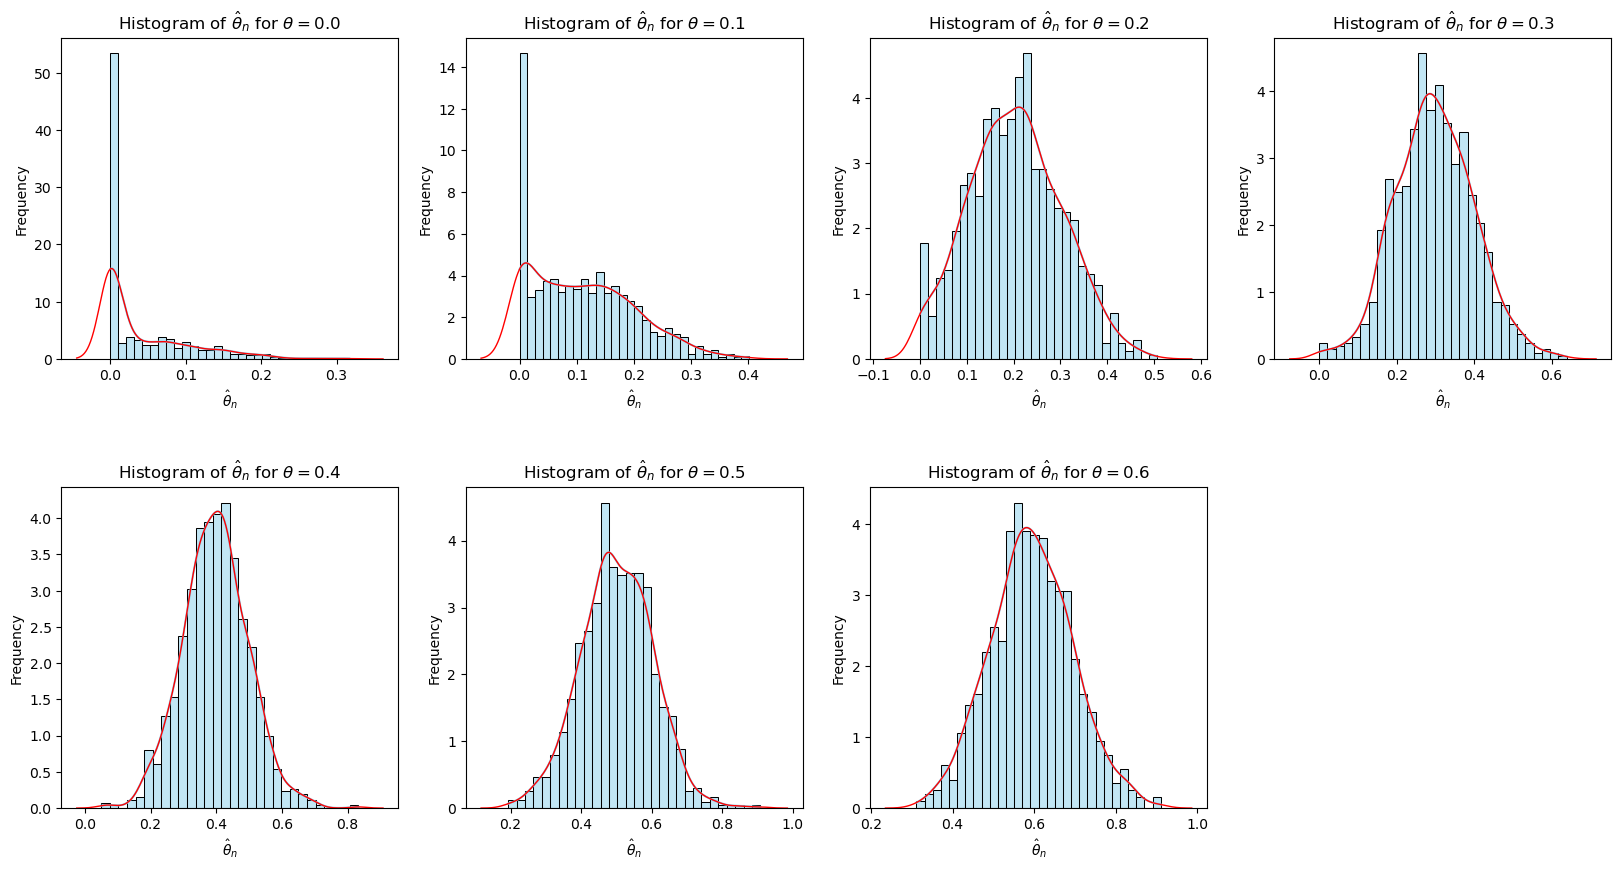

Theta = 0.0: Mean of estimates = 0.0402, Std Dev = 0.0595
Theta = 0.1: Mean of estimates = 0.1105, Std Dev = 0.0894
Theta = 0.2: Mean of estimates = 0.2028, Std Dev = 0.0983
Theta = 0.3: Mean of estimates = 0.2985, Std Dev = 0.1009
Theta = 0.4: Mean of estimates = 0.3978, Std Dev = 0.0992
Theta = 0.5: Mean of estimates = 0.5016, Std Dev = 0.1018
Theta = 0.6: Mean of estimates = 0.5938, Std Dev = 0.1007


In [3]:
## histogram and 1000 MOnte Carlo to investigate the non-normality  of the estimator in formula 1 
## how the distribution of theta hat changes as theta increases
theta=np.arange(0.0, 0.7, 0.1)
n=100
REP=1000
BOOTREP=9999

np.random.seed(42)

## MC simulation
thetahat=np.zeros((len(theta),REP))

for b in range(REP):
    for i, th in enumerate(theta):
        epsilon=np.random.normal(0, 1, n)
        y=th+epsilon
        ybar=np.mean(y)    ## the y bar
        
        thetahat[i,b]=max((0,ybar))

## Draw the graphs
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, th in enumerate(theta):
    ax = axes[i]
    sns.histplot(thetahat[i, :], kde=True, bins=30, ax=ax, stat="density",color="skyblue")
    sns.kdeplot(thetahat[i, :], ax=ax, color="red", linewidth=1)

    ax.set_title(f"Histogram of $\\hat{{\\theta}}_n$ for $\\theta = {th:.1f}$")
    ax.set_xlabel("$\\hat{\\theta}_n$")
    ax.set_ylabel("Frequency")

# Remove any empty subplots
for j in range(len(theta), len(axes)):
    fig.delaxes(axes[j])
plt.subplots_adjust(hspace=0.4) # Adjust the distance between the row
plt.show()
for i, th in enumerate(theta):
    mean_estimate = np.mean(thetahat[i, :])
    std_estimate = np.std(thetahat[i, :])
    print(f"Theta = {th:.1f}: Mean of estimates = {mean_estimate:.4f}, Std Dev = {std_estimate:.4f}")


### The parametric residual bootstrap
# thetahatB=np.zeros(BOOTREP)                # initialise to zero

# for i in range(len(theta)):
#     for b in range(BOOTREP):
#         index=np.random.randint(n,size=n)
#         resB=epsilon[index]
#         yB=ybar[i]+resB

#         thetahatB[b]



    



### Question 2


In [4]:
from scipy.stats import jarque_bera, shapiro, anderson

# For reproducibility
np.random.seed(42)

# Parameters
theta_values = np.arange(0, 0.7, 0.1)
n_values = [100, 400]
sim = 1000
alpha = 0.05 # Significance level

# Function for bootstrap testing
def bootstrap_test(theta, n, alpha):
    eps = np.random.normal(0, 1, size=n)
    y = theta + eps
    theta_hat = max(0, np.mean(y))  # QMLE

    # Bootstrap sample (m=n)
    theta_B = []
    for _ in range(n):
        epsilon_B = np.random.normal(0, 1, size=n)
        y_B = theta_hat + epsilon_B
        theta_B.append(max(0, np.mean(y_B)))

    # To store test results
    test_results = {}

    # Jarque-Bera Test (Robust)
    test_results["Jarque-Bera"] = jarque_bera(theta_B).pvalue < alpha

    # Anderson-Darling Test
    stat_AD, crit_value_AD, _ = anderson(theta_B, dist='norm')
    test_results["Anderson-Darling"] = stat_AD > crit_value_AD[2] # The index for 5% according to: (0:15%,1:10%,2:5%,3:2.5%,4:1%)

    # Shapiro-Wilk Test
    test_results["Shapiro-Wilk"] = shapiro(theta_B).pvalue < alpha

    # Lilliefors Test
    test_results["Lilliefors"] = lilliefors(theta_B, dist='norm')[1] < alpha

    # Doornik-Hansen Test
    test_results["Doornik-Hansen"] = omni_normtest(theta_B)[1] < alpha

    return test_results

results = []

# Simulation
for n in n_values:
    for theta in theta_values:
        rejections = {test: 0 for test in [
            "Jarque-Bera", "Anderson-Darling",
            "Shapiro-Wilk", "Lilliefors", "Doornik-Hansen"
        ]}

        # Perform simulations
        for mc in tqdm(range(sim), desc=f"n={n}, theta={theta}"):
            test_results = bootstrap_test(theta, n, alpha)
            for test, rejected in test_results.items():
                rejections[test] += rejected

        # Store results
        results.append({
            "n": n,
            "theta": theta,
            **{test: rejections[test] / sim for test in rejections}
        })

results_df = pd.DataFrame(results)

# Separate the table into two parts based on n
results_n_100 = results_df[results_df['n'] == 100]
results_n_400 = results_df[results_df['n'] == 400]

# Print the tables separately
print("\nRejection levels at 5% significance level for n = 100:")
print(results_n_100.to_string(index=False))

print("\nRejection levels at 5% significance level for n = 400:")
print(results_n_400.to_string(index=False))

n=400, theta=0.6000000000000001: 100%|██████████| 1000/1000 [00:03<00:00, 254.15it/s]


Rejection levels at 5% significance level for n = 100:
  n  theta  Jarque-Bera  Anderson-Darling  Shapiro-Wilk  Lilliefors  Doornik-Hansen
100    0.0        0.843             0.905         0.939       0.878           0.876
100    0.1        0.537             0.654         0.735       0.596           0.603
100    0.2        0.191             0.302         0.381       0.256           0.256
100    0.3        0.067             0.078         0.113       0.071           0.091
100    0.4        0.042             0.046         0.044       0.054           0.058
100    0.5        0.038             0.038         0.039       0.047           0.051
100    0.6        0.049             0.055         0.058       0.048           0.057

Rejection levels at 5% significance level for n = 400:
  n  theta  Jarque-Bera  Anderson-Darling  Shapiro-Wilk  Lilliefors  Doornik-Hansen
400    0.0        0.964             0.962         0.987       0.959           0.967
400    0.1        0.400             0.414       

### Question 3

NameError: name 'stats' is not defined

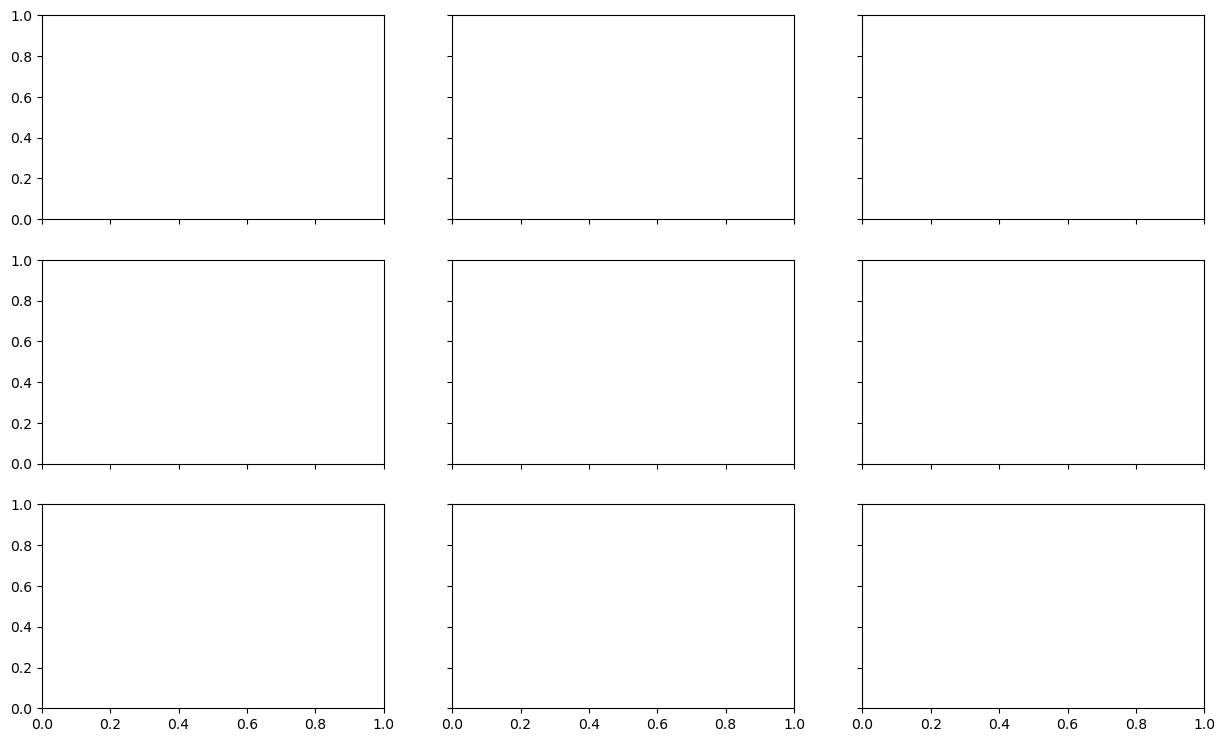

In [5]:
import statsmodels.api as sm

theta=0
n=[100,200,400]
dfs=[1,2,5] ## degree of freedom
REP=1000

np.random.seed(42)

## MC simulation
fig, axes = plt.subplots(
    nrows=len(dfs),
    ncols=len(n),
    figsize=(15, 9),
    sharex=True,  # Share x-axis
    sharey=True   # Share y-axis
)
axes = axes.ravel()
plot_idx = 0

for size in n:
    for df in dfs:
        thetahats=[]
        for _ in range(REP):
            epsilon=np.random.standard_t(df, size)
            y=theta+epsilon
            thetahat=np.mean(y)    
            thetahats.append(thetahat)
        ax = axes[plot_idx]
        stats.probplot(thetahats, dist="norm", plot=ax)
        plot_idx += 1

plt.tight_layout()
plt.show()




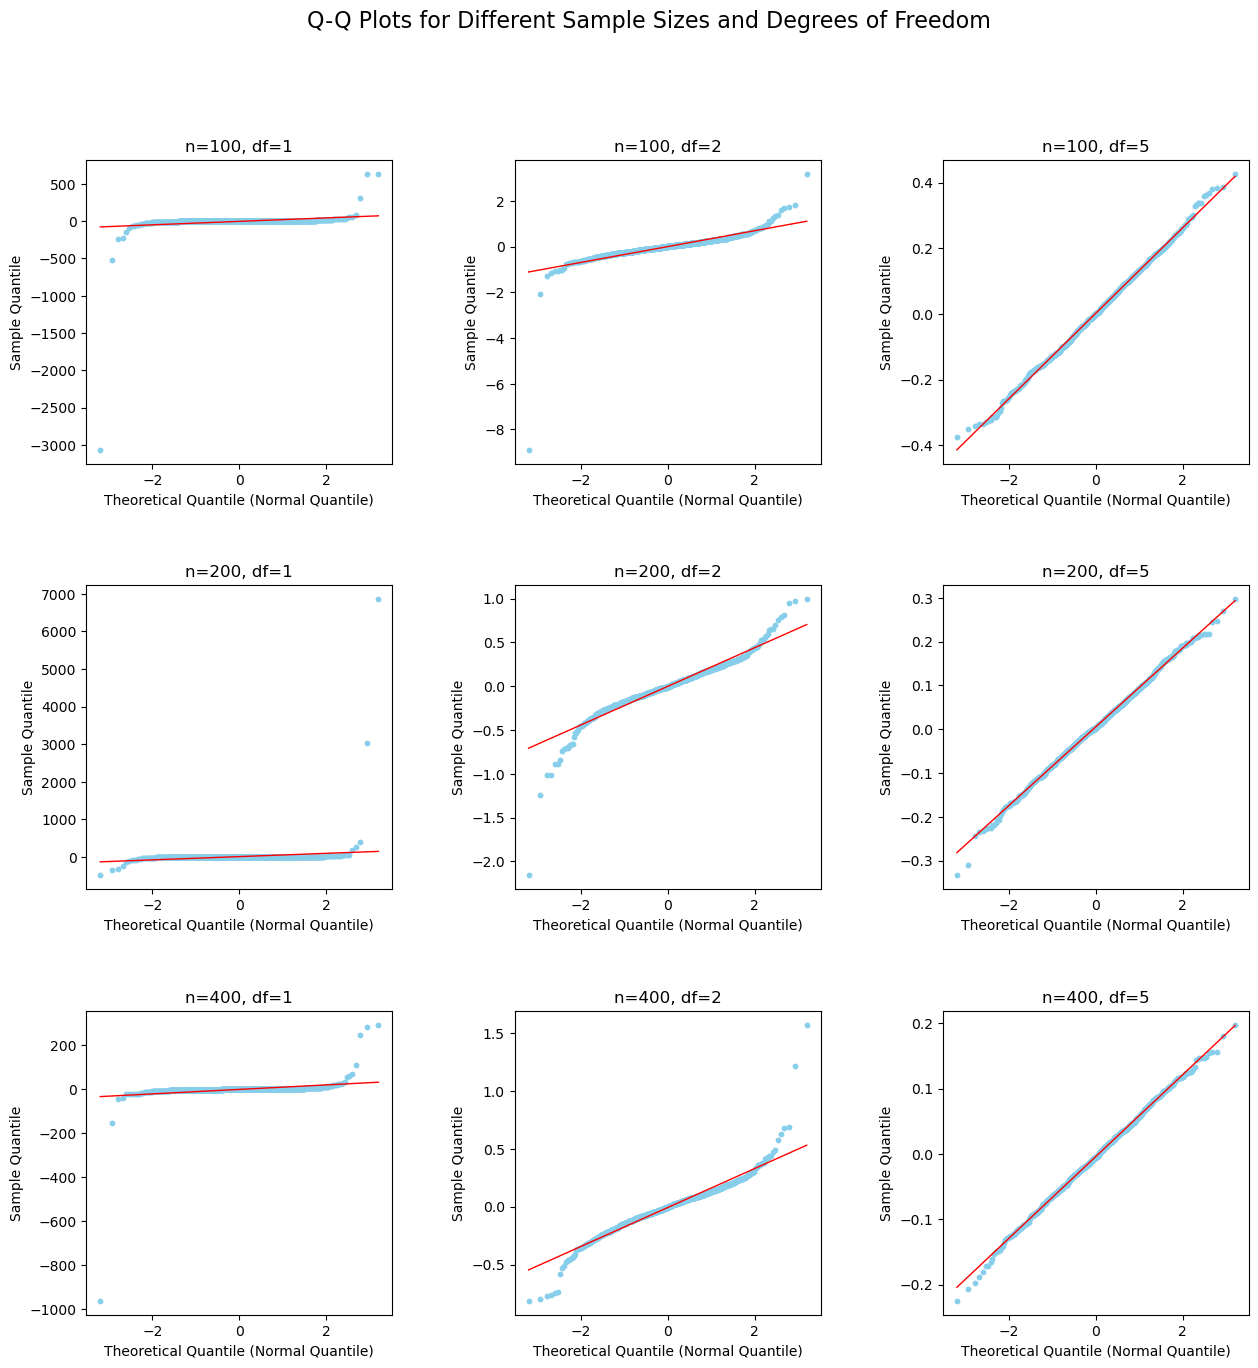

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Parameters
theta = 0  # True parameter
n = [100, 200, 400]  # Sample sizes
dfs = [1, 2, 5]  # Degrees of freedom for t-distribution
REP = 1000  # Number of Monte Carlo repetitions

np.random.seed(42)  # Set seed for reproducibility

# Create a 3x3 grid for Q-Q plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

# Monte Carlo simulation
plot_idx = 0  # Track subplot index
for size in n:
    for df in dfs:
        thetahats = []  # Store sample means
        for _ in range(REP):
            # Generate epsilon from t-distribution
            epsilon = np.random.standard_t(df, size)
            y = theta + epsilon  # Generate y values
            thetahat = np.mean(y)  # Compute sample mean
            thetahats.append(thetahat)

        row, col = divmod(plot_idx, 3)  
        osm, osr = stats.probplot(thetahats, dist="norm")[0] ## theoretical quantile and ordered sample quantiles
        axes[row, col].scatter(osm, osr, color='skyblue', s=10)  
        slope, intercept, _ = stats.probplot(thetahats, dist="norm")[1]
        axes[row, col].plot(osm, slope * osm + intercept, 'r', lw=1) 
        axes[row, col].set_title(f"n={size}, df={df}")
        axes[row, col].set_xlabel("Theoretical Quantile (Normal Quantile)")
        axes[row, col].set_ylabel("Sample Quantile")
        plot_idx += 1

plt.suptitle("Q-Q Plots for Different Sample Sizes and Degrees of Freedom", fontsize=16)
plt.show()



## Question 5

In [7]:
from scipy.stats import shapiro, anderson
from scipy.stats import anderson, cramervonmises, shapiro, norm, zscore
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import jarque_bera

import jinja2

In [66]:
# --- SETTING AND FUNCTIONS ---

# --- Set random seed for reproducibility ---
np.random.seed(42)

# --- DGP ----
sample_sizes = [100, 200, 400] # possible sample sizes

# Parameters
c_array = [0, 50, 1000] # possible values for the numerator of pi
beta_array = np.linspace(-3,3,10) # possible values for beta
sigma_eps = 1
sigma_u = 1
sigma_z = 1
cov_eps_u = 0.7
cov_matrix_eps_u = [[sigma_eps**2, cov_eps_u], [cov_eps_u, sigma_u**2]]

# Define a function to generate the data
def generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u):
    # Generate epsilon and u with the specified covariance matrix
    eps, u = np.random.multivariate_normal([0, 0], cov_matrix_eps_u, n).T

    # Generate z
    z = np.random.normal(0, sigma_z, n)

    # Generate x
    x = c/np.sqrt(n) * z + u

    # Generate y
    y = beta*x + eps

    return y, x, z

# Define a function to estimate pi_hat and beta_hat
def two_sls(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Estimate beta_hat
    beta_hat = np.sum(z*y)/np.sum(z*x)

    # Compute residuals from 2nd stage regression
    eps_hat = y - beta_hat*x

    # Compute standard error of beta_hat
    s_2 = np.sum(eps_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(x_hat**2))  # standard error of 2SLS estimator
    #  np.sqrt (s_2 * np.sum(z*z) / np.sum((z*x)**2)) this formula is equivalent, but gives numerical instability

    # Return fitted residuals
    return beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat

# --- Bootstrap procedure ---
# Define a function to run the bootstrap procedure
def bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat, boot_rep=None):

    if boot_rep is None:
        boot_rep = round(n**(4/5))  # default number of bootstrap replications

    pi = c / np.sqrt(n) # compute pi from c and n
    w = np.vstack((u_hat, eps_hat)).T  # make pairs

    beta_hat_star = np.zeros(boot_rep)  # initialize array to store bootstrapped regression coefficient for beta_hat
    se_beta_hat_star = np.zeros(boot_rep)  # initialize array to store bootstrapped standard error for beta_hat
    t_star = np.zeros(boot_rep)  # initialize array to store bootstrapped t-statistic

    for b in range(boot_rep):
        # resample bootstrap residuals from fitted residuals
        index = np.random.randint(n, size=n)  # select the indices
        w_star = np.copy(w[index,])  # resample the pairs
        u_star = w_star[:,0]
        eps_star = w_star[:,1]

        # Generate x_star
        x_star = pi_hat*z + u_star

        # Generate y_star
        y_star = beta_hat*x_star + eps_star

        # Generate bootstrapped estimates
        data = two_sls(y_star,x_star,z) # obtain bootstrap estimates using two_sls function
        beta_hat_star[b] = data[0] # store bootstrapped regression coefficient for beta_hat
        se_beta_hat_star[b] = data[4] # store bootstrapped standard error for beta_hat
        t_star[b] = (beta_hat_star[b] - beta_hat) / se_beta_hat_star[b] # store bootstrapped t-statistic

        # APPROACH 2 - alternative with synthetic formula
        # t_star[b] = np.sum(z*eps_star) / np.sum(z*x_star) * se_beta_hat_star[b]

        # Debugging line
        # Print state of bootstrap procedure
        # print(f"completion of bootstrap: {(b / boot_rep) * 100:.2f}%")

    return t_star, beta_hat_star, se_beta_hat_star

In [16]:
# --- MONTECARLO SIMULATION ---

# Set random seed for reproducibility
np.random.seed(42)

# We simulate the bootstrap procedure
# for each combination of sample size, c, and beta for MC_rep times
# and store the results of the Shapiro-Wilk test on the t_statistic
# (i.e., the t_star standardized by the standard error of beta_hat as in the last formula of page 3)

MC_rep = 1000 # number of MonteCarlo simulations
MC_results = [] # store the results of the MonteCarlo simulation

inst_relevance = None

# Calculate the total number of iterations
total_iterations = len(sample_sizes) * len(c_array) * len(beta_array) * MC_rep
current_iteration = 0

# Loop over the combinations of sample size, c, and beta
for n in sample_sizes:

    for c in c_array:
        # label the instrument relevance
        if c == 0:
            inst_relevance = 'irrelevant'
        elif c == 50:
            inst_relevance = 'weak'
        elif c == 1000:
            inst_relevance = 'strong'

        for beta in beta_array:

            for i in range(MC_rep):
                # Generate the data
                y, x, z = generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u)

                # Draw the original sample and estimate the parameters
                beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

                # Bootstrap the data
                t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0] # use default value for boot_rep

                # Run the Shapiro-Wilk test on t_star
                shapiro_result = shapiro(t_star)
                statistic = round(shapiro_result.statistic, 4)
                pvalue = round(shapiro_result.pvalue, 4)
                reject_5 = pvalue < 0.05
                reject_1 = pvalue < 0.01

                # Store the results
                MC_results.append({
                    'n': n,
                    'pi': c / (n**0.5),
                    'instrument_relevance': inst_relevance,
                    'beta': beta,
                    'statistic': statistic,
                    'pvalue': pvalue,
                    'reject_5': reject_5,
                    'reject_1': reject_1
                }) # create a Dataframe indexed by n, pi=c/sqrt(n), beta, with as columns the results of the test

                # Update and print state of the simulation
                current_iteration += 1
                total_completion = (current_iteration / total_iterations) * 100
                print(f"Completion of Monte Carlo: {total_completion:.2f}%")


Completion of Monte Carlo: 0.00%
Completion of Monte Carlo: 0.00%
Completion of Monte Carlo: 0.00%
Completion of Monte Carlo: 0.00%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.01%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.02%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion of Monte Carlo: 0.03%
Completion

In [17]:
# --- RESULTS ---
# Create a DataFrame from the results
MC_results_df = pd.DataFrame(MC_results)

# Compute statistics (mean and std) and rejection frequencies
summary_df = MC_results_df.groupby(['n', 'instrument_relevance', 'beta']).agg(
    pvalue_mean=('pvalue', 'mean'),
    rejection_freq_5_percent=('reject_5', 'mean'),
    rejection_freq_1_percent=('reject_1', 'mean')
).reset_index()

# Convert pvalue_mean, rejection_freq_5_percent, and rejection_freq_1_percent to percentage and round to the second decimal
summary_df['pvalue_mean'] = (summary_df['pvalue_mean'] ).round(2)
summary_df['rejection_freq_5_percent'] = (summary_df['rejection_freq_5_percent'] * 100).round(2)
summary_df['rejection_freq_1_percent'] = (summary_df['rejection_freq_1_percent'] * 100).round(2)

summary_df.columns = [
    'Sample size', 'Instrument relevance', 'β', 'Mean p-value', 'Rejection frequency at 5%', 'Rejection frequency at 1%'
]

instrument_relevance_order = CategoricalDtype(
    ['irrelevant', 'weak', 'strong'],
    ordered=True
)

summary_df['Instrument relevance'] = summary_df['Instrument relevance'].astype(instrument_relevance_order)

# Set multilevel index
summary_df.set_index(['Sample size', 'Instrument relevance', 'β'], inplace=True)

summary_df.sort_index(level=['Sample size', 'Instrument relevance', 'β'], inplace=True)

# Highlighting function for values
def highlight_rejection(val):
    if val > 70:
        return 'background-color: lightcoral;'  # Light orange
    elif val > 50:
        return 'background-color: lightyellow;'  # Light yellow
    return ''

# Define caption
caption_html = """
    <b style="font-size: larger;">Shapiro-Wilk Normality test: Monte Carlo simulation summary</b><br>
    <i>1000 MC replications; bootstrapping with m=n<sup>4/5</sup></i><br>
    <i>yellow cells = rejection frequency &gt; 50%; red cells = rejection frequency &gt; 70%.</i>
"""

# Combine both highlighting and borders
styled_df = (summary_df
    .style
    .map(highlight_rejection, subset=['Rejection frequency at 5%', 'Rejection frequency at 1%'])
    .set_caption(caption_html)
)

# Format all cells inside table body to have 2 decimal places
styled_df = styled_df.format(precision=2)

# Format the 'β' index to have 2 decimal places
styled_df = styled_df.format_index(level='β', precision=2)

# Generate the list of styles
step = len(beta_array)
total_steps = len(sample_sizes) * len(c_array) * len(beta_array)

styles = []

for i in range(0, total_steps, step):
    styles.append({
        'selector': f'tbody tr:nth-child(n+{1+i}):nth-child(-n+{i+step})',
        'props': [
            ('border', '1px solid black')
        ]
    })

# Set table styles collectively
styled_df = styled_df.set_table_styles(styles)

# Display the styled DataFrame
styled_df

## Question6

In [18]:
# --- PRODUCE DATA ---

# Set random seed for reproducibility
np.random.seed(42)

# --- Parameters ---

# We redefine the parameters for the bootstrap procedure
beta = 2    # we choose a fixed value for beta for illustrative purposes
c_array_new = [0, 50, 100, 1000] # possible values for the numerator of pi
sample_size = 100
m = sample_size # number of bootstrap replications
n_samples = 4 # number of samples to generate

# --- Bootstrap procedure ---

# We generate 4 samples for each possible value of c

# At each iteration we store the t_star statistic
# (standardized by the standard error of beta_hat as in the last formula of page 3)

# We simulate the procedure 1000 times to obtain a larger sample of t_star statistics

results_six = [] # list to store the results

# initialize categorical variable for instrument relevance
inst_relevance = None

# Calculate the total number of iterations
total_iterations = len(c_array_new) * n_samples * MC_rep
current_iteration = 0

# Loop over the possible values of c

for c in c_array_new:
    # label the instrument relevance
    if c == 0:
        inst_relevance = 'irrelevant'
    elif c == 50:
        inst_relevance = 'weak'
    elif c == 100:
        inst_relevance = 'moderate'
    elif c == 1000:
        inst_relevance = 'strong'

    for i in range(MC_rep): # run 1000 simulations
        for s in range(n_samples): # generate 4 samples
            # Generate the data
            y, x, z = generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u)

            # Draw the original sample and estimate the parameters
            beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

            # Bootstrap the data
            t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat, boot_rep=m)[0]

            # Store the results
            results_six.append({
                'c': c,
                'pi': c / (n**0.5),
                'instrument_relevance': inst_relevance,
                't_star': t_star
            }) # create a Dataframe with computed t_star

            # Update and print state of the simulation
            current_iteration += 1
            total_completion = (current_iteration / total_iterations) * 100
            print(f"Completion of bootstrap: {total_completion:.2f}%")

# Store the results in a DataFrame
results_six = pd.DataFrame(results_six)


Completion of bootstrap: 0.01%
Completion of bootstrap: 0.01%
Completion of bootstrap: 0.02%
Completion of bootstrap: 0.03%
Completion of bootstrap: 0.03%
Completion of bootstrap: 0.04%
Completion of bootstrap: 0.04%
Completion of bootstrap: 0.05%
Completion of bootstrap: 0.06%
Completion of bootstrap: 0.06%
Completion of bootstrap: 0.07%
Completion of bootstrap: 0.07%
Completion of bootstrap: 0.08%
Completion of bootstrap: 0.09%
Completion of bootstrap: 0.09%
Completion of bootstrap: 0.10%
Completion of bootstrap: 0.11%
Completion of bootstrap: 0.11%
Completion of bootstrap: 0.12%
Completion of bootstrap: 0.12%
Completion of bootstrap: 0.13%
Completion of bootstrap: 0.14%
Completion of bootstrap: 0.14%
Completion of bootstrap: 0.15%
Completion of bootstrap: 0.16%
Completion of bootstrap: 0.16%
Completion of bootstrap: 0.17%
Completion of bootstrap: 0.18%
Completion of bootstrap: 0.18%
Completion of bootstrap: 0.19%
Completion of bootstrap: 0.19%
Completion of bootstrap: 0.20%
Completi

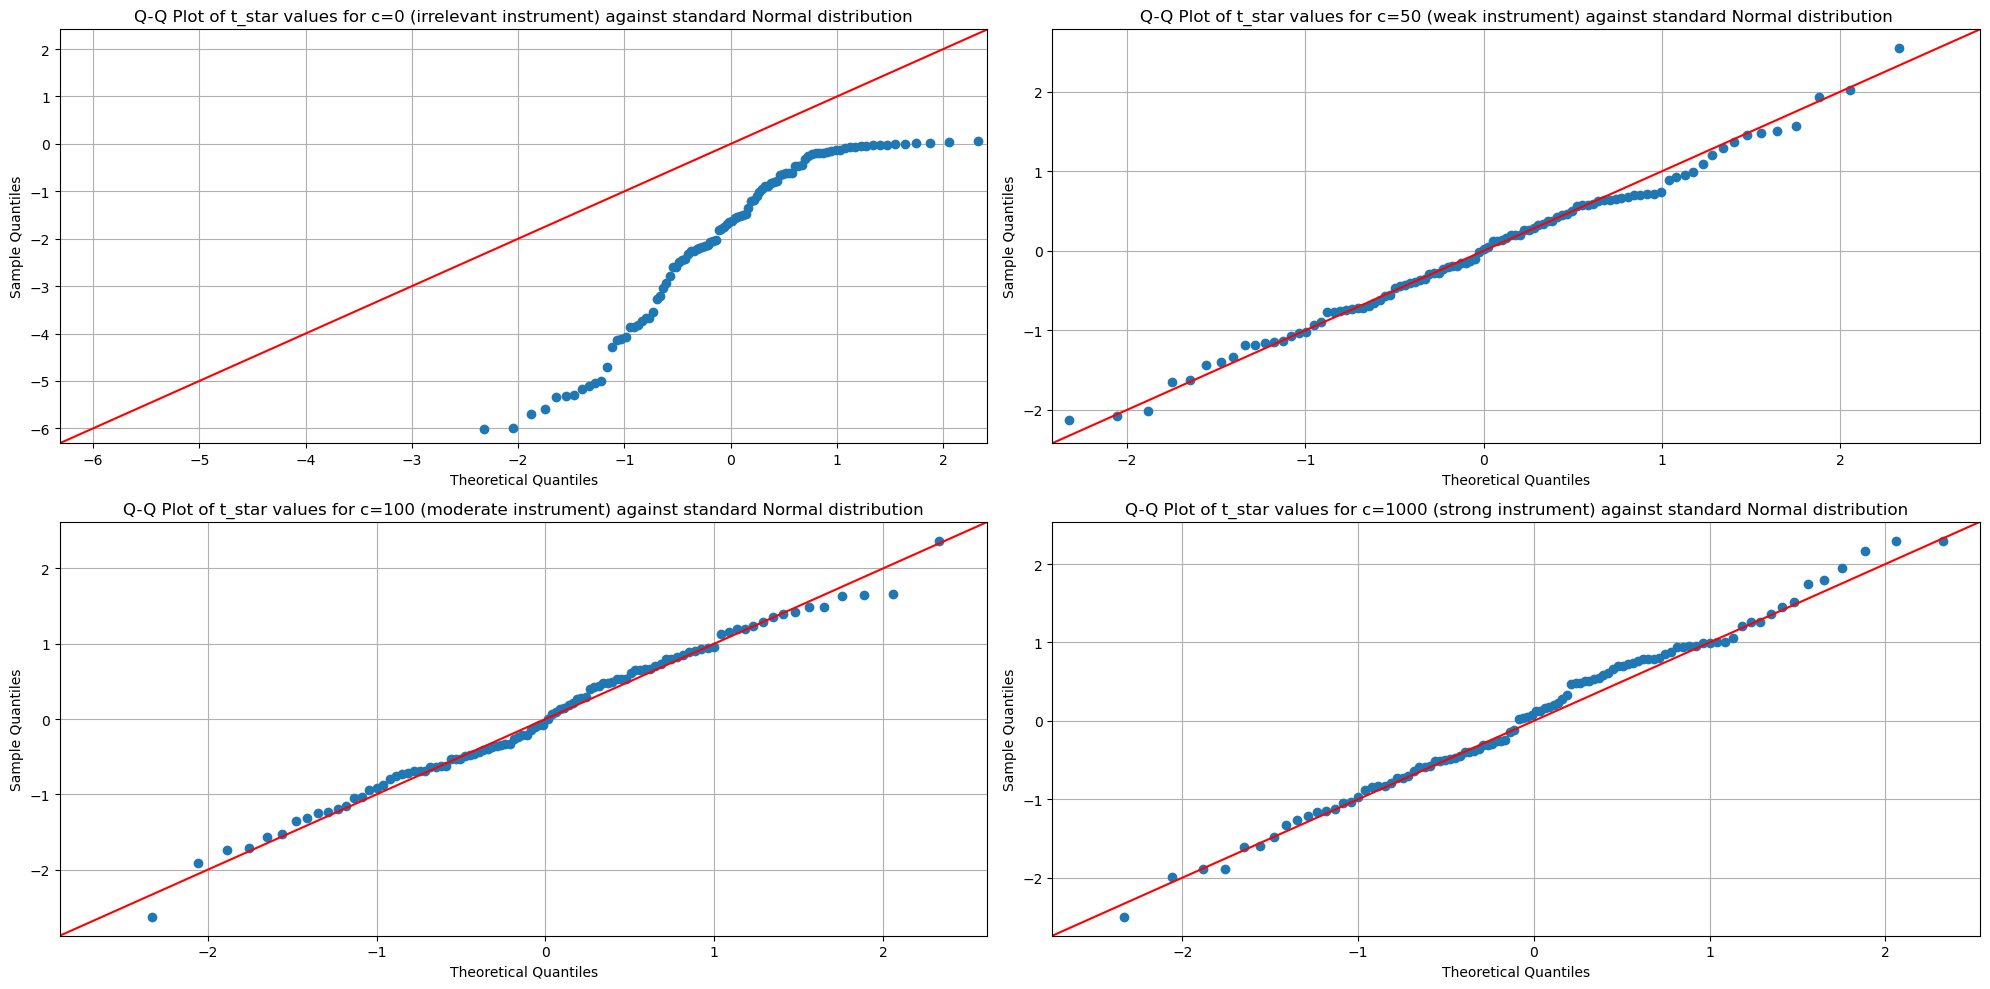

In [19]:
# --- QQ PLOTS ---

# Plot the Q-Q plot for each value of inst_relevance in MC_results_new

fig_qq, axs_qq = plt.subplots(2, 2, figsize=(20, 10))

for i, c in enumerate(c_array_new):
    # Extract t_star values for the current pi_value
    subset_t_star = results_six[results_six['c'] == c]['t_star'].values[0]
    inst_relevance = results_six[results_six['c'] == c]['instrument_relevance'].values[0]

    # Remove outliers using Z-score method
    z_scores = zscore(subset_t_star)
    subset_t_star_filtered = subset_t_star[(z_scores > -3) & (z_scores < 3)]

    # Q-Q plot against standard normal distribution
    sm.qqplot(subset_t_star_filtered, line='45', dist=norm, ax=axs_qq[i // 2, i % 2])
    axs_qq[i // 2, i % 2].set_title(f'Q-Q Plot of t_star values for c={c} ({inst_relevance} instrument) against standard Normal distribution')
    axs_qq[i // 2, i % 2].grid(True)

plt.tight_layout()
plt.show()


## Quesiton 7

## Question 8

In [67]:
# Function for bootstrap testing

## First find the critical value under the null
def calculate_critical_value(n, c, beta, MC_rep=1000, alpha=0.05):
    """
    Calculate the critical value for d_n under the null hypothesis.
    
    Parameters:
        n (int): Sample size.
        c (float): Strength of instruments (irrelevant, weak, strong).
        beta (float): True beta under null (e.g., beta = 0).
        MC_rep (int): Number of Monte Carlo replications.
        alpha (float): Significance level (default is 5%).
    
    Returns:
        float: Critical value for d_n at the given alpha.
    """
    d_n_values = []
    
    for _ in range(MC_rep):
        # Generate data under the null hypothesis
        y, x, z = generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u)
        
        # Estimate parameters using 2SLS
        beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)
        
        # Bootstrap the data
        t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0]
        
        # Compute d_n for this replication
        d_n = compute_dn(t_star)
        d_n_values.append(d_n)
    
    # Calculate the critical value as the 1 - alpha quantile of the null distribution
    critical_value = np.percentile(d_n_values, 100 * (1 - alpha))
    return critical_value

def compute_dn(t_star, x_min=1.96, x_max=5, num_points=1000):
    # Sort the bootstrap sample to compute the empirical CDF
    t_star_sorted = np.sort(t_star)
    n = len(t_star_sorted)
    
    # Define the empirical CDF G_hat(x)
    def G_hat(x):
        return np.searchsorted(t_star_sorted, x, side='right') / n

    # Create a grid of x values from x_min to x_max
    x_values = np.linspace(x_min, x_max, num_points)

    # Compute the absolute differences |G_hat(x) - Phi(x)|
    differences = np.abs([G_hat(x) - norm.cdf(x) for x in x_values])

    # Return the supremum of the differences
    return np.max(differences)

In [68]:
# --- SETTING AND FUNCTIONS ---

# --- Set random seed for reproducibility ---
np.random.seed(42)

# --- DGP ----
sample_sizes = [100, 200, 400] # possible sample sizes

# Parameters
c_array = [0, 50, 1000] # possible values for the numerator of pi
beta_array = np.linspace(-3,3,10) # possible values for beta
sigma_eps = 1
sigma_u = 1
sigma_z = 1
cov_eps_u = 0.7
cov_matrix_eps_u = [[sigma_eps**2, cov_eps_u], [cov_eps_u, sigma_u**2]]

# Define a function to generate the data
def generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u):
    # Generate epsilon and u with the specified covariance matrix
    eps, u = np.random.multivariate_normal([0, 0], cov_matrix_eps_u, n).T

    # Generate z
    z = np.random.normal(0, sigma_z, n)

    # Generate x
    x = c/np.sqrt(n) * z + u

    # Generate y
    y = beta*x + eps

    return y, x, z

# Define a function to estimate pi_hat and beta_hat
def two_sls(y, x, z):

    n = len(y)

    # Estimate pi_hat
    pi_hat = np.sum(x*z)/np.sum(z**2)

    # Compute residuals from 1st stage regression
    x_hat = pi_hat*z
    u_hat = x - x_hat

    # Estimate beta_hat
    beta_hat = np.sum(z*y)/np.sum(z*x)

    # Compute residuals from 2nd stage regression
    eps_hat = y - beta_hat*x

    # Compute standard error of beta_hat
    s_2 = np.sum(eps_hat**2) / (n - 1)  # residual variance; (n-1) because we only have 1 regressor and no intercept
    se_beta_hat = np.sqrt (s_2 / np.sum(x_hat**2))  # standard error of 2SLS estimator
    #  np.sqrt (s_2 * np.sum(z*z) / np.sum((z*x)**2)) this formula is equivalent, but gives numerical instability

    # Return fitted residuals
    return beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat

# --- Bootstrap procedure ---
# Define a function to run the bootstrap procedure
def bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat, boot_rep=None):

    if boot_rep is None:
        boot_rep = round(n**(4/5))  # default number of bootstrap replications

    pi = c / np.sqrt(n) # compute pi from c and n
    w = np.vstack((u_hat, eps_hat)).T  # make pairs

    beta_hat_star = np.zeros(boot_rep)  # initialize array to store bootstrapped regression coefficient for beta_hat
    se_beta_hat_star = np.zeros(boot_rep)  # initialize array to store bootstrapped standard error for beta_hat
    t_star = np.zeros(boot_rep)  # initialize array to store bootstrapped t-statistic

    for b in range(boot_rep):
        # resample bootstrap residuals from fitted residuals
        index = np.random.randint(n, size=n)  # select the indices
        w_star = np.copy(w[index,])  # resample the pairs
        u_star = w_star[:,0]
        eps_star = w_star[:,1]

        # Generate x_star
        x_star = pi_hat*z + u_star

        # Generate y_star
        y_star = beta_hat*x_star + eps_star

        # Generate bootstrapped estimates
        data = two_sls(y_star,x_star,z) # obtain bootstrap estimates using two_sls function
        beta_hat_star[b] = data[0] # store bootstrapped regression coefficient for beta_hat
        se_beta_hat_star[b] = data[4] # store bootstrapped standard error for beta_hat
        t_star[b] = (beta_hat_star[b] - beta_hat) / se_beta_hat_star[b] # store bootstrapped t-statistic

        # APPROACH 2 - alternative with synthetic formula
        # t_star[b] = np.sum(z*eps_star) / np.sum(z*x_star) * se_beta_hat_star[b]

        # Debugging line
        # Print state of bootstrap procedure
        # print(f"completion of bootstrap: {(b / boot_rep) * 100:.2f}%")

    return t_star, beta_hat_star, se_beta_hat_star

## Question 9


Wild Bootstrap P-Value: 0.41911619398659045
Weighted Residual Bootstrap P-Value: 0.1167728679828638


## Question 8

In [69]:
import numpy as np
import pandas as pd
from scipy.stats import norm, shapiro

# Define a function to compute \hat{d}_n
# Given bootstrap t_star and a significance level alpha
def compute_dn(t_star, x_min=1.96, x_max=5, num_points=1000):

    # Sort the bootstrap sample to compute the empirical CDF
    t_star_sorted = np.sort(t_star)
    n = len(t_star_sorted)
    
    # Define the empirical CDF G_hat(x)
    def G_hat(x):
        return np.searchsorted(t_star_sorted, x, side='right') / n

    # Create a grid of x values from x_min to x_max
    x_values = np.linspace(x_min, x_max, num_points)

    # Compute the absolute differences |G_hat(x) - Phi(x)|
    differences = np.abs([G_hat(x) - norm.cdf(x) for x in x_values])

    # Return the supremum of the differences
    return np.max(differences)

# Generate the null distribution for d_n

def generate_null_distribution(n, c, beta, MC_rep=1000):
   
    d_n_values = []

    for _ in range(MC_rep):
        # Generate the data
        y, x, z = generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u)
        
        # Estimate parameters
        beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

        # Bootstrap the data
        t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0]

        # Compute \hat{d}_n for this replication
        d_n = compute_dn(t_star)
        d_n_values.append(d_n)

    return np.array(d_n_values)

# Calculate the critical value for \hat{d}_n
def calculate_critical_value(n, c, beta, MC_rep=1000, alpha=0.05):
   
    null_d_n = generate_null_distribution(n, c, beta, MC_rep)
    critical_value = np.percentile(null_d_n, 100 * (1 - alpha))
    return critical_value

# --- Simulation ---

MC_rep = 1000  # Number of Monte Carlo simulations
critical_values = []  # Store critical values
results_combined = []  

for n in sample_sizes:
    for c in c_array:
        inst_relevance = 'irrelevant' if c == 0 else 'weak' if c == 50 else 'strong'

        # Generate null distribution and critical value for \hat{d}_n
        critical_value = calculate_critical_value(n, c, beta=0, MC_rep=MC_rep, alpha=0.05)
        critical_values.append({'Sample size': n, 'Instrument relevance': inst_relevance, 'Critical value': critical_value})

        for beta in beta_array:
            for _ in range(MC_rep):
                # Generate the data
                y, x, z = generate_data(n, c, beta, sigma_eps, sigma_u, sigma_z, cov_eps_u)

                # Estimate parameters
                beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

                # Bootstrap the data
                t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0]

                # Compute \hat{d}_n
                d_n = compute_dn(t_star)

                # Check if \hat{d}_n exceeds the critical value
                reject = d_n > critical_value

                # Store the result
                results_combined.append({
                    'Sample size': n,
                    'Instrument relevance': inst_relevance,
                    'Beta': beta,
                    'd_n': d_n,
                    'Reject': reject
                })

# Convert results to DataFrame
critical_values_df = pd.DataFrame(critical_values)
results_combined_df = pd.DataFrame(results_combined)

# Summarize rejection frequencies
summary_combined = results_combined_df.groupby(['Sample size', 'Instrument relevance', 'Beta']).agg(
    Rejection_Frequency=('Reject', 'mean')
).reset_index()


In [33]:
print("Critical Values for \\hat{d}_n")
print(critical_values_df)
print("\nRejection Frequencies ")
print(summary_combined)



Critical Values for \hat{d}_n
   Sample size Instrument relevance  Critical value
0          100           irrelevant        0.507416

Rejection Frequencies 
                                       Mean d_n  Rejection frequency (%)
Sample size Instrument relevance β                                      
100         irrelevant           -3.0  0.120486                     7.69


In [70]:
import dataframe_image as dfi
# Convert results to DataFrame
critical_values_df = pd.DataFrame(critical_values)
results_combined_df = pd.DataFrame(results_combined)

# Compute statistics and rejection frequencies
summary_combined = results_combined_df.groupby(['Sample size', 'Instrument relevance', 'Beta']).agg(
    Mean_d_n=('d_n', 'mean'),
    Rejection_Frequency=('Reject', 'mean')
).reset_index()

# Convert frequencies to percentages
summary_combined['Rejection_Frequency'] = (summary_combined['Rejection_Frequency'] * 100).round(2)

# Style and display the results
summary_combined.columns = [
    'Sample size', 'Instrument relevance', 'β', 'Mean d_n', 'Rejection frequency (%)'
]
summary_combined.set_index(['Sample size', 'Instrument relevance', 'β'], inplace=True)
summary_combined.sort_index(level=['Sample size', 'Instrument relevance', 'β'], inplace=True)

# Define a highlighting function
def highlight_rejection(val):
    if val > 50:
        return 'background-color: lightcoral;'  # Red for high rejection
    elif val > 25:
        return 'background-color: lightyellow;'  # Yellow for moderate rejection
    return ''

# Style the DataFrame
styled_summary_combined = (
    summary_combined.style
    .applymap(highlight_rejection, subset=['Rejection frequency (%)'])
    .set_table_styles([
        {"selector": "table", "props": [("border", "2px solid black"), ("border-collapse", "collapse")]},
        {"selector": "th", "props": [("border", "2px solid black"), ("padding", "5px")]},
        {"selector": "td", "props": [("border", "2px solid black"), ("padding", "5px")]}
    ])
    .format(precision=2)
    .set_caption(
        "<b>Rejection Frequencies </b><br>"
        "<i>1000 MC replications; bootstrap-based critical values.</i>"
    )
)

# Display the styled DataFrame
styled_summary_combined
dfi.export(styled_summary_combined, 'full_table_question_8.png', max_rows=-1, max_cols=-1, dpi=300)

/var/folders/37/1816qp916w797616r1v9n33m0000gn/T/ipykernel_32464/549809585.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_rejection, subset=['Rejection frequency (%)'])


In [72]:
critical_values_df
dfi.export(critical_values_df, 'critical_values_question_7.png', max_rows=-1, max_cols=-1, dpi=300)

## Question 8 correct


In [ ]:
# --- QUESTION 8 ---

# Define a function to compute \hat{d}_n
# Given bootstrap t_star and a significance level alpha
def compute_dn(t_star, x_min=1.96, x_max=5, num_points=1000):

    # Compute the empirical CDF
    G_hat = ECDF(t_star)

    # Create a grid of x values from x_min to x_max
    x_values = np.linspace(x_min, x_max, num_points)

    # Compute the absolute differences |G_hat(x) - Phi(x)|
    differences = np.abs([G_hat(x) - norm.cdf(x) for x in x_values])

    # Return the supremum of the differences
    return np.max(differences)

# Generate the null distribution for d_n

def generate_null_distribution(n, MC_rep=1000):
    d_n_values = []
    m = round(n**(4/5)) # number of bootstrap replications

    for _ in range(MC_rep):
        # Generate m boostrap samples from a normal(0,1) distribution
        bootstrap_samples = np.random.normal(0, 1, m)

        # Compute \hat{d}_n for this replication
        d_n = compute_dn(bootstrap_samples)
        d_n_values.append(d_n)

    return np.array(d_n_values)

# Calculate the critical value for \hat{d}_n
def calculate_critical_value(n, MC_rep=1000, alpha=0.05):
    null_d_n = generate_null_distribution(n, MC_rep)
    critical_value = np.percentile(null_d_n, 100 * (1 - alpha))
    return critical_value

In [ ]:
# --- SIMULATION ---

beta_value = beta_array[7]  # we choose again a value 1.67 for beta for illustrative purposes
MC_rep = 100  # Number of Monte Carlo simulations
critical_values = []  # Store critical values
results_combined = []

# Debugging lines to compute the total number of iterations in the loop
# total_iterations = len(sample_sizes) * len(c_array) * MC_rep
# current_iteration = 0

for n in sample_sizes:
    # Generate null distribution and critical value for \hat{d}_n
    critical_value = calculate_critical_value(n, MC_rep=MC_rep, alpha=0.05)
    critical_values.append({'Sample size': n, 'Critical value': critical_value})

    for c in c_array:
        inst_relevance = 'irrelevant' if c == 0 else 'weak' if c == 50 else 'strong'

        for _ in range(MC_rep):
            # Generate the data
            y, x, z = generate_data(n, c, beta_value, sigma_eps, sigma_u, sigma_z, cov_eps_u)

            # Estimate parameters
            beta_hat, pi_hat, eps_hat, u_hat, se_beta_hat = two_sls(y, x, z)

            # Bootstrap the data
            t_star = bootstrap_dgp(n, c, z, pi_hat, beta_hat, u_hat, eps_hat)[0]

            # Compute \hat{d}_n
            d_n = compute_dn(t_star)

            # Check if \hat{d}_n exceeds the critical value
            reject = d_n > critical_value

            # Store the result
            results_combined.append({
                'Sample size': n,
                'Instrument relevance': inst_relevance,
                'Beta': beta_value,
                'd_n': d_n,
                'Reject': reject
            })

            # Debugging lines
            # Update and print state of the simulation
            # current_iteration += 1
            # total_completion = (current_iteration / total_iterations) * 100
            # print(f"Completion of bootstrap: {total_completion:.2f}%")

# Convert results to DataFrame
critical_values_df = pd.DataFrame(critical_values)
results_combined_df = pd.DataFrame(results_combined)

In [ ]:
# --- PRINTING RESULTS ---

# Summarize rejection frequencies

# Compute statistics and rejection frequencies
summary_combined = results_combined_df.groupby(['Sample size', 'Instrument relevance', 'Beta']).agg(
    Mean_d_n=('d_n', 'mean'),
    Rejection_Frequency=('Reject', 'mean')
).reset_index()

# Convert frequencies to percentages
summary_combined['Rejection_Frequency'] = (summary_combined['Rejection_Frequency'] * 100).round(2)

# Style and display the results
summary_combined.columns = [
    'Sample size', 'Instrument relevance', 'β', 'Mean d_n', 'Rejection frequency (%)'
]
summary_combined.set_index(['Sample size', 'Instrument relevance', 'β'], inplace=True)
summary_combined.sort_index(level=['Sample size', 'Instrument relevance', 'β'], inplace=True)

# Define a highlighting function
def highlight_rejection(val):
    if val > 70:
        return 'background-color: lightcoral;'  # Red for high rejection
    elif val > 50:
        return 'background-color: lightyellow;'  # Yellow for moderate rejection
    return ''

# Style the DataFrame
styled_summary_combined = (
    summary_combined.style
    .applymap(highlight_rejection, subset=['Rejection frequency (%)'])
    .format(precision=2)
    .set_caption(
        "<b>Rejection Frequencies </b><br>"
        "<i>100 MC replications; bootstrap-based critical values.</i>"
    )
)

# Display the styled DataFrame
styled_summary_combined

# Export to png
# dfi.export(styled_summary_combined, 'rejection_table_question_8.png', max_rows=-1, max_cols=-1, dpi=300)

In [ ]:
# Display the table with critical values
critical_values_df

# Export to png
# dfi.export(critical_values_df, 'critical_values_question_8.png', max_rows=-1, max_cols=-1, dpi=300)